In [22]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from src.regex_pattern_generator import generate_regex_patterns

plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [23]:
CONTEXT_WINDOW = 200  # words to display for context


Define Search Phrases

Matching rules:
- singular, possessive, plural, and hyphenated compounds
- allow trailing punctuation
- words separated by a slash are synonyms for a single phrase


In [24]:
PHRASES = ['Win',
'SeatGeek',
'Jet',
'Insane',
'Feastable',
'Charity',
'Water',
'Time',
'Survive',
'Subscribe',
'Prize',
'Money',
'Million',
'Island',
'Elimination',
'Contestant',
'Challenge',
'Camera',
'Beast',
'Acquisition']

SEARCH_PHRASES = generate_regex_patterns(PHRASES)

from pprint import pprint
pprint(SEARCH_PATTERNS)

{'Acquisition': "\\b(?:\\w+-)*(?:acquisition|acquisitions|acquisition's|acquisitions')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Beast': "\\b(?:\\w+-)*(?:beast|beasts|beast's|beasts')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Camera': "\\b(?:\\w+-)*(?:camera|cameras|camera's|cameras')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Challenge': "\\b(?:\\w+-)*(?:challenge|challenges|challenge's|challenges')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Charity': "\\b(?:\\w+-)*(?:charity|charities|charity's|charitys'|charities')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Contestant': "\\b(?:\\w+-)*(?:contestant|contestants|contestant's|contestants')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Elimination': "\\b(?:\\w+-)*(?:elimination|eliminations|elimination's|eliminations')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Feastable': "\\b(?:\\w+-)*(?:feastable|feastables|feastable's|feastables')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Insane': "\\b(?:\\w+-)*(?:insane|insanes|insane's|insanes')(?:-\\w+)*(?=\\W|$)[.,!?;:]*",
 'Island': "\\b(?:\\w+-)*(?:island|islands|island's|islands'

In [25]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    counts = {}
    lower_text = text.lower()
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, lower_text))
    return counts


def parse_upload_date(val: str) -> datetime:
    # Expecting format like 20250801 or ISO; try multiple formats
    s = str(val).strip()
    for fmt in ("%Y%m%d", "%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(s, fmt)
        except Exception:
            continue
    # Fallback to pandas to_datetime
    try:
        return pd.to_datetime(s).to_pydatetime()
    except Exception:
        return pd.NaT


def find_phrase_context(text, pattern, window=CONTEXT_WINDOW):
    matches = []
    lower_text = text.lower()
    for match in re.finditer(pattern, lower_text):
        start = max(0, match.start() - window)
        end = min(len(lower_text), match.end() + window)
        snippet = lower_text[start:end]
        if start > 0:
            snippet = '...' + snippet
        if end < len(lower_text):
            snippet = snippet + '...'
        matches.append(snippet)
    return matches


In [26]:
# Load Mr. Beast transcripts CSV
CSV_PATH = "/Users/jstenger/Documents/repos/kalshi-research/data-beast/dataset_yt-transcript_2025-08-15_00-40-14-138.csv"

# Read with pandas; the file has embedded newlines inside quoted fields, so use python engine
raw = pd.read_csv(CSV_PATH, engine='python')

# Keep only necessary columns
# Expect columns: url, title, duration, uploadDate, language, text
cols = [c for c in raw.columns if c in ['url','title','duration','uploadDate','language','text']]
df_raw = raw[cols].copy()

# Normalize date
df_raw['date'] = df_raw['uploadDate'].apply(parse_upload_date)

# Drop rows without text
df_raw = df_raw[df_raw['text'].astype(str).str.len() > 0].copy()

# Compute counts
records = []
for _, row in df_raw.iterrows():
    text = str(row['text'])
    counts = count_phrases(text)
    rec = {
        'date': row['date'],
        'title': row.get('title', ''),
        'url': row.get('url', ''),
        'text_length': len(text.split()),
        'text': text,
    }
    rec.update(counts)
    records.append(rec)

df = pd.DataFrame(records).sort_values('date')

print("Dataset Statistics:")
print(f"Total videos: {len(df)}")
print("\nWord Count Statistics:")
print(f"Average length: {df['text_length'].mean():.0f} words")
print("\nDate Range:")
if pd.notna(df['date'].min()) and pd.notna(df['date'].max()):
    print(f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
else:
    print("No valid dates")


Dataset Statistics:
Total videos: 60

Word Count Statistics:
Average length: 3853 words

Date Range:
2022-12-24 to 2025-08-30


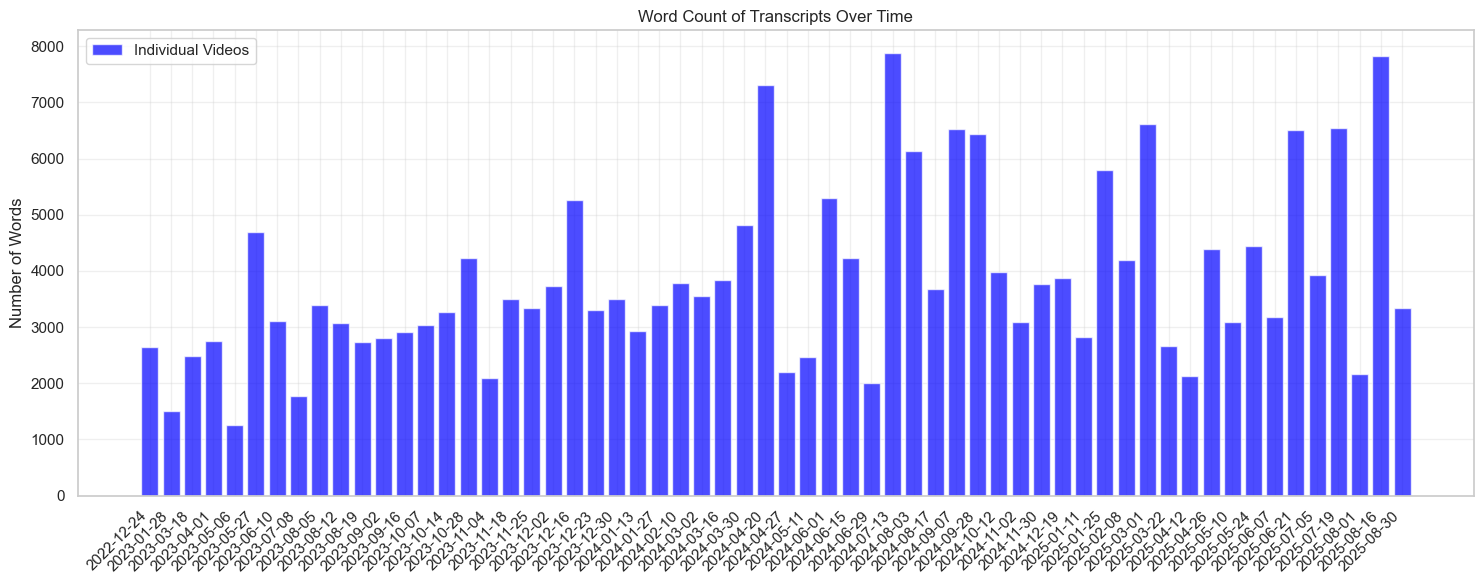


Word Count Summary:
Mean word count: 3853
Median word count: 3446
Min word count: 1260
Max word count: 7887


In [27]:
# Plot total word counts over time as a bar chart
plt.figure(figsize=(15, 6))

df_sorted = df.sort_values('date')
x_positions = range(len(df_sorted))

plt.bar(x_positions, df_sorted['text_length'], alpha=0.7, color='blue', label='Individual Videos')
plt.xticks(x_positions, [d.strftime('%Y-%m-%d') if pd.notna(d) else '' for d in df_sorted['date']], rotation=45, ha='right')
plt.title('Word Count of Transcripts Over Time')
plt.xlabel('')
plt.ylabel('Number of Words')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

print("\nWord Count Summary:")
print(f"Mean word count: {df['text_length'].mean():.0f}")
print(f"Median word count: {df['text_length'].median():.0f}")
print(f"Min word count: {df['text_length'].min():.0f}")
print(f"Max word count: {df['text_length'].max():.0f}")


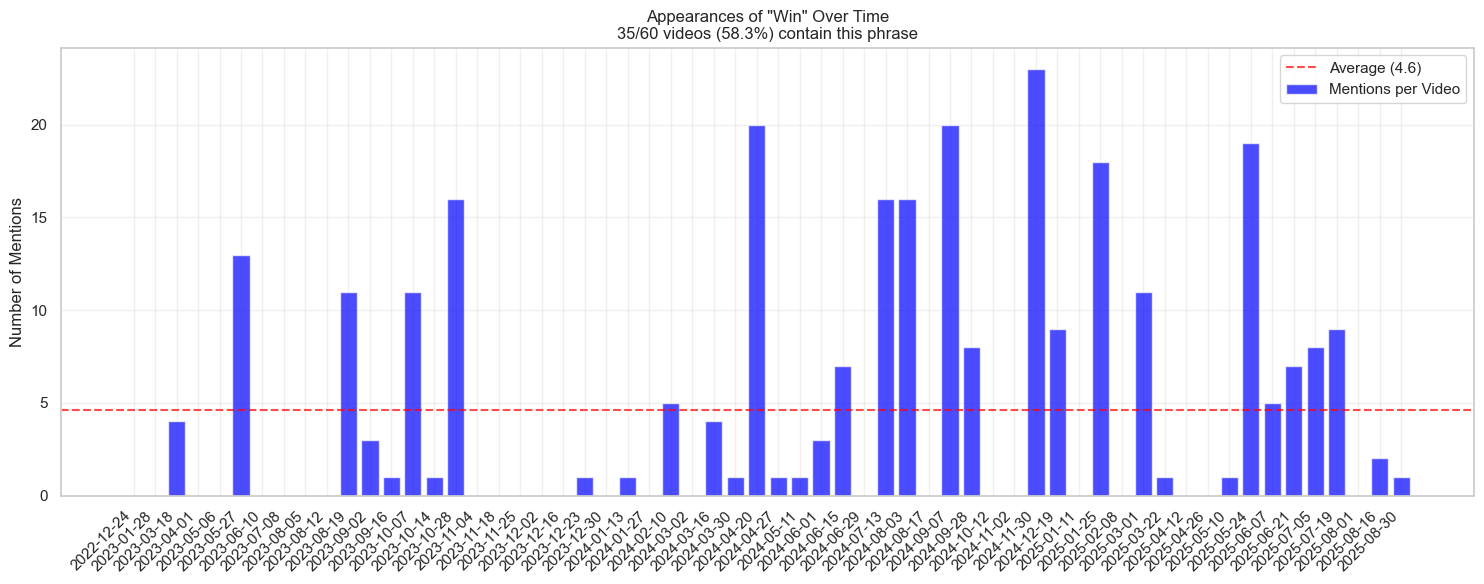

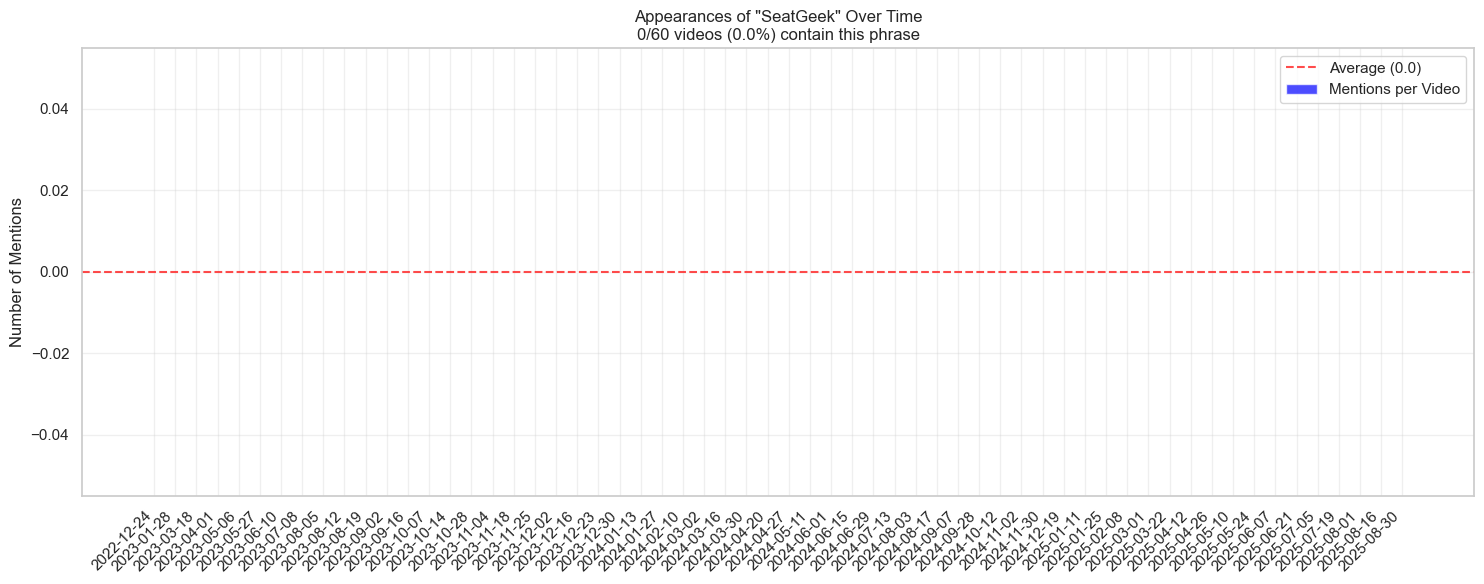

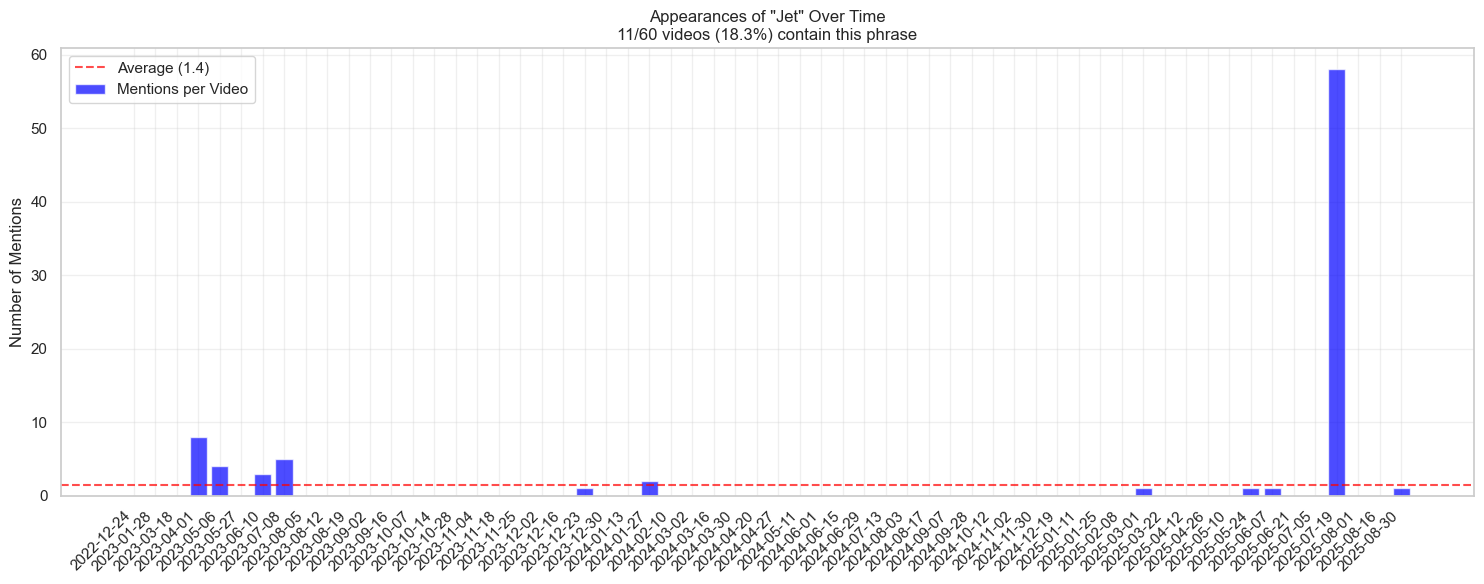

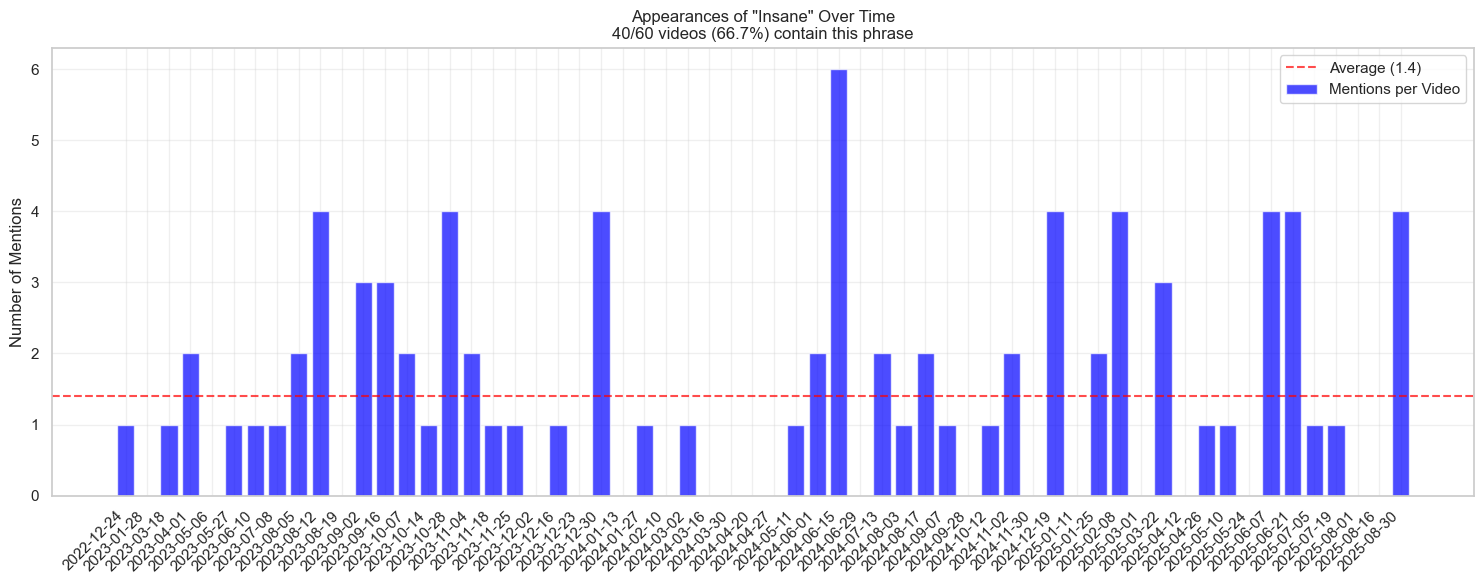

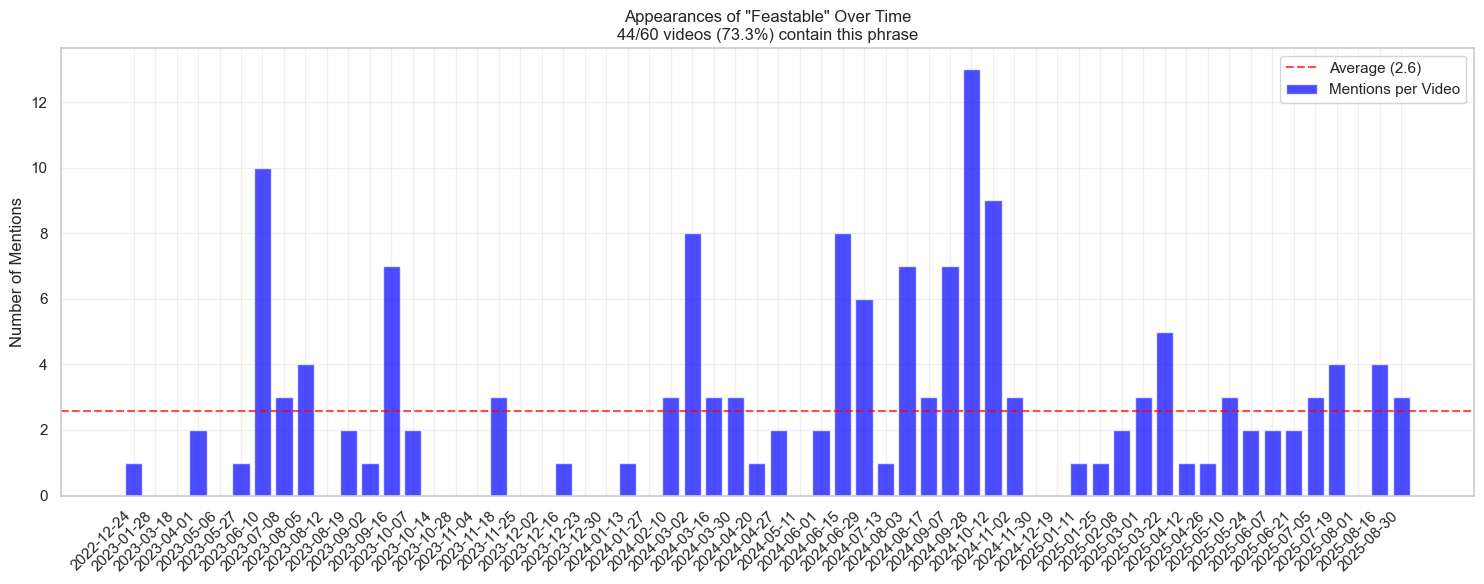

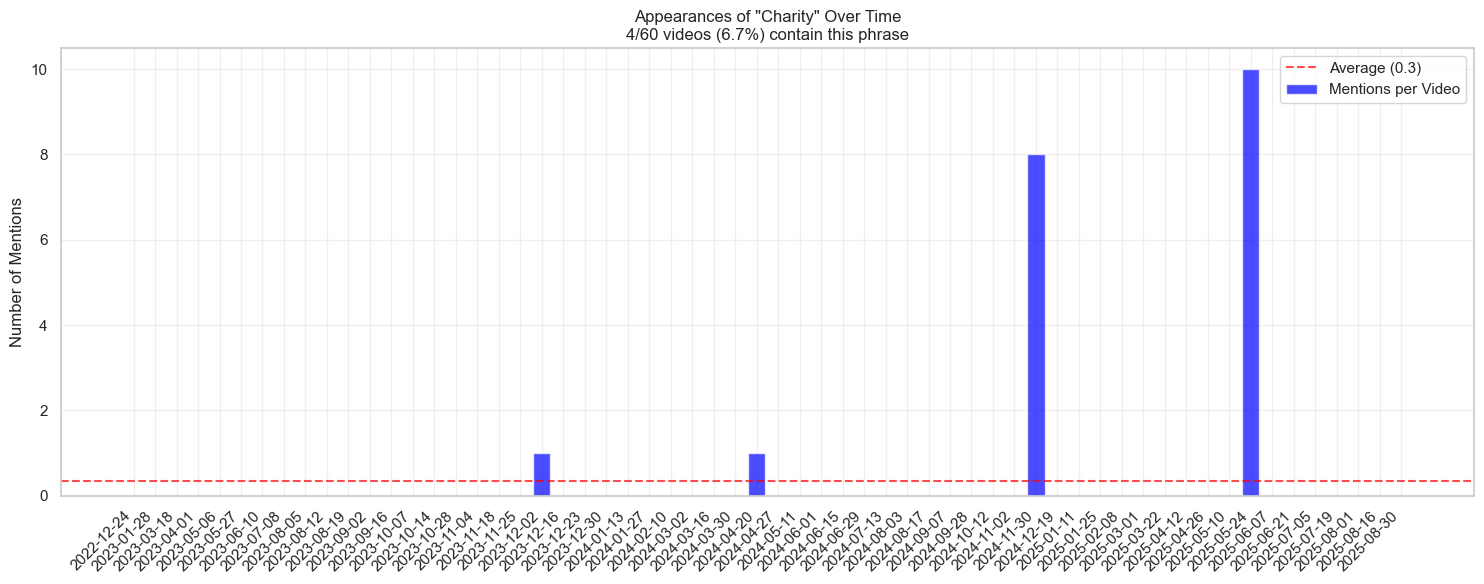

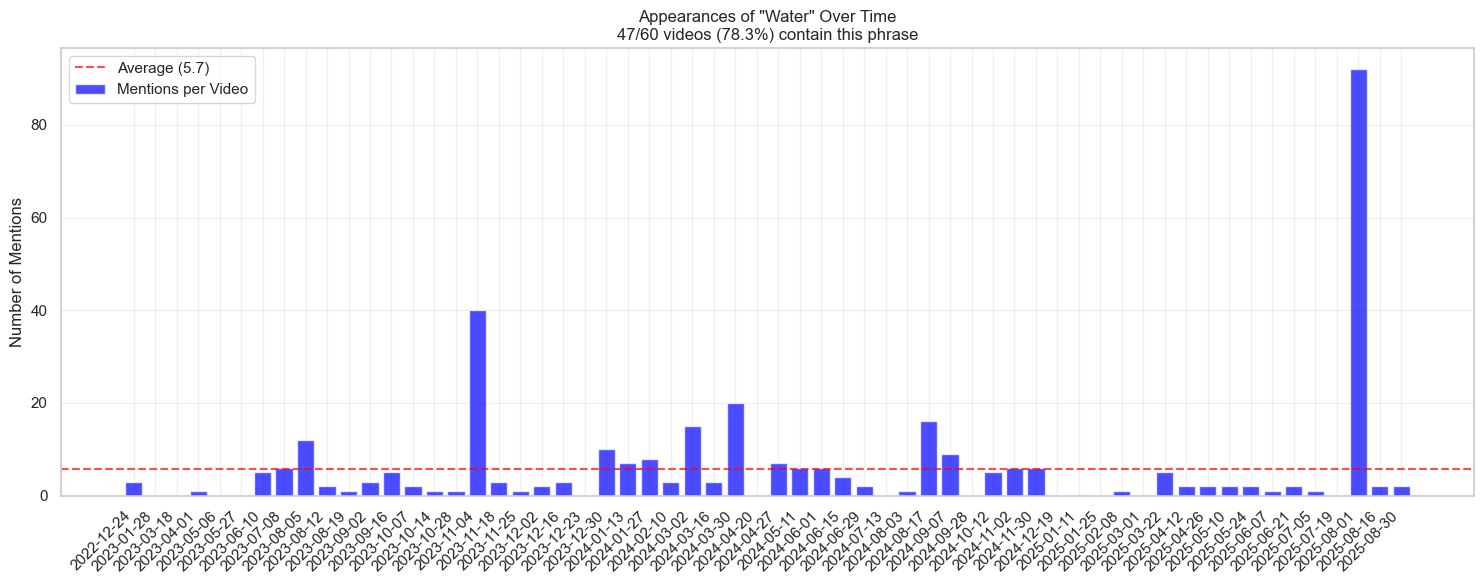

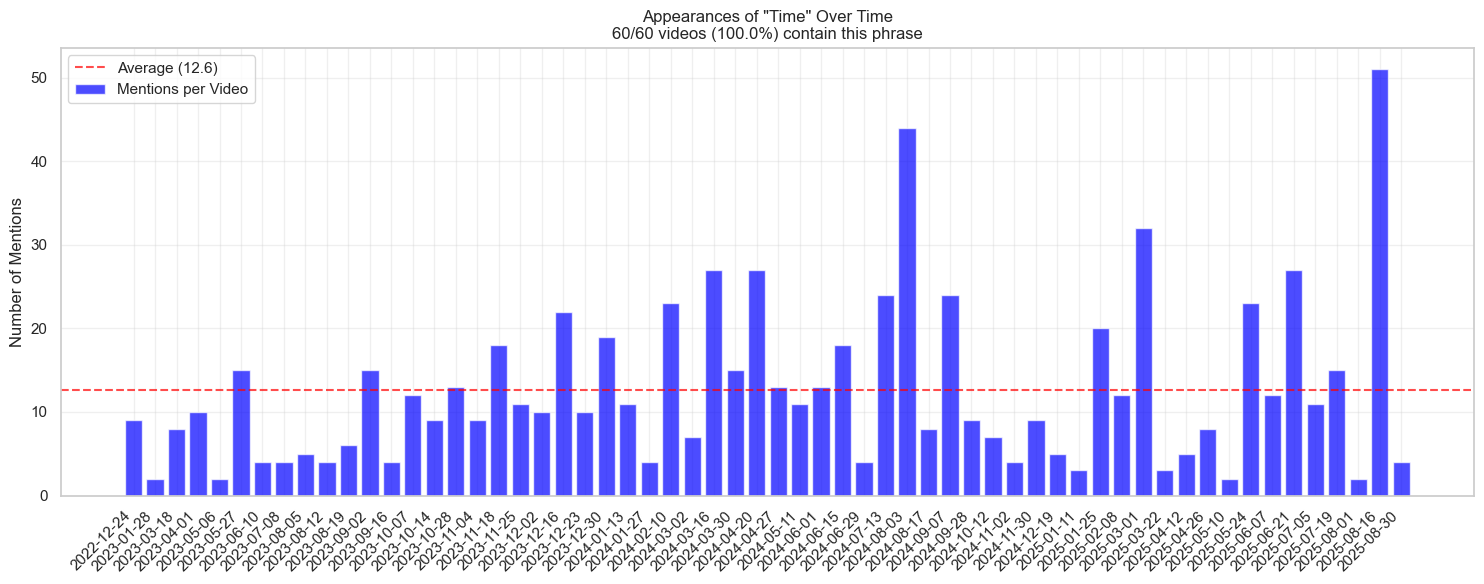

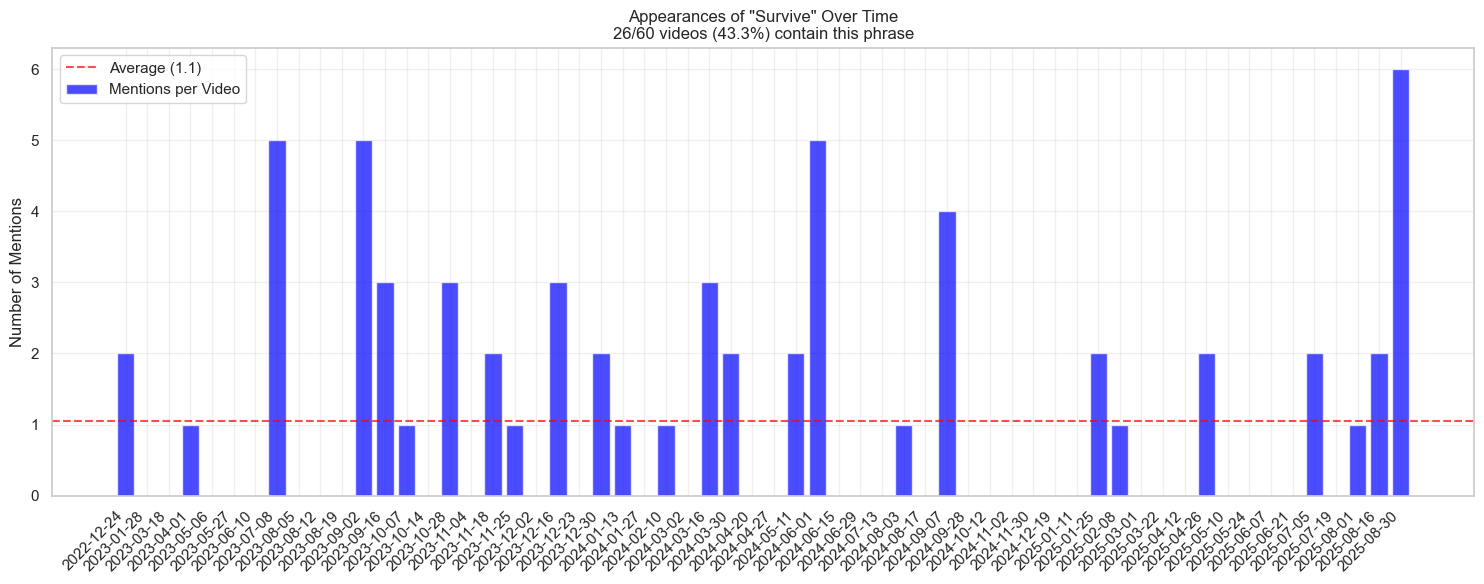

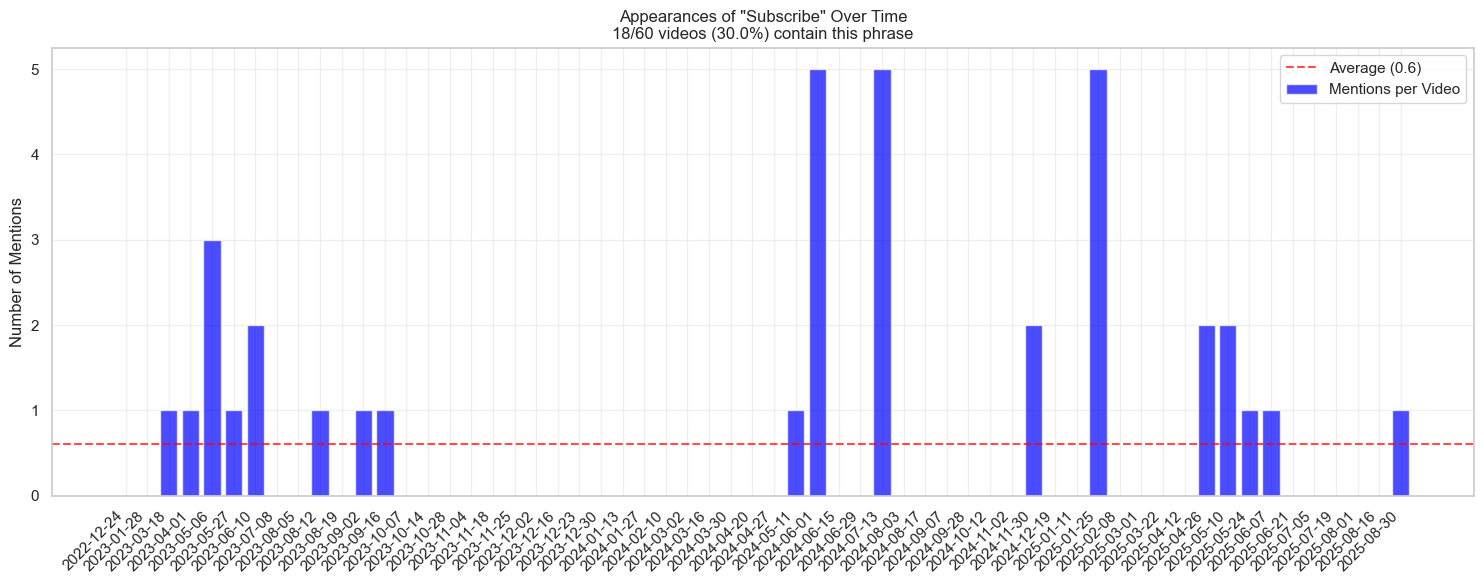

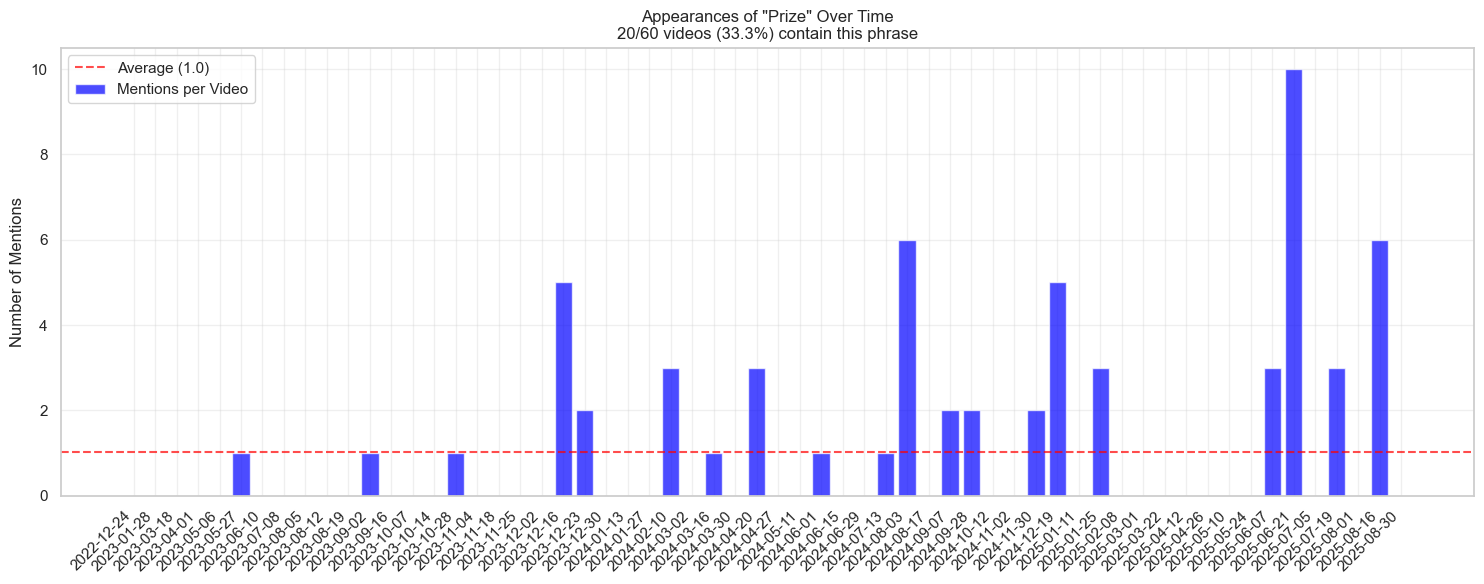

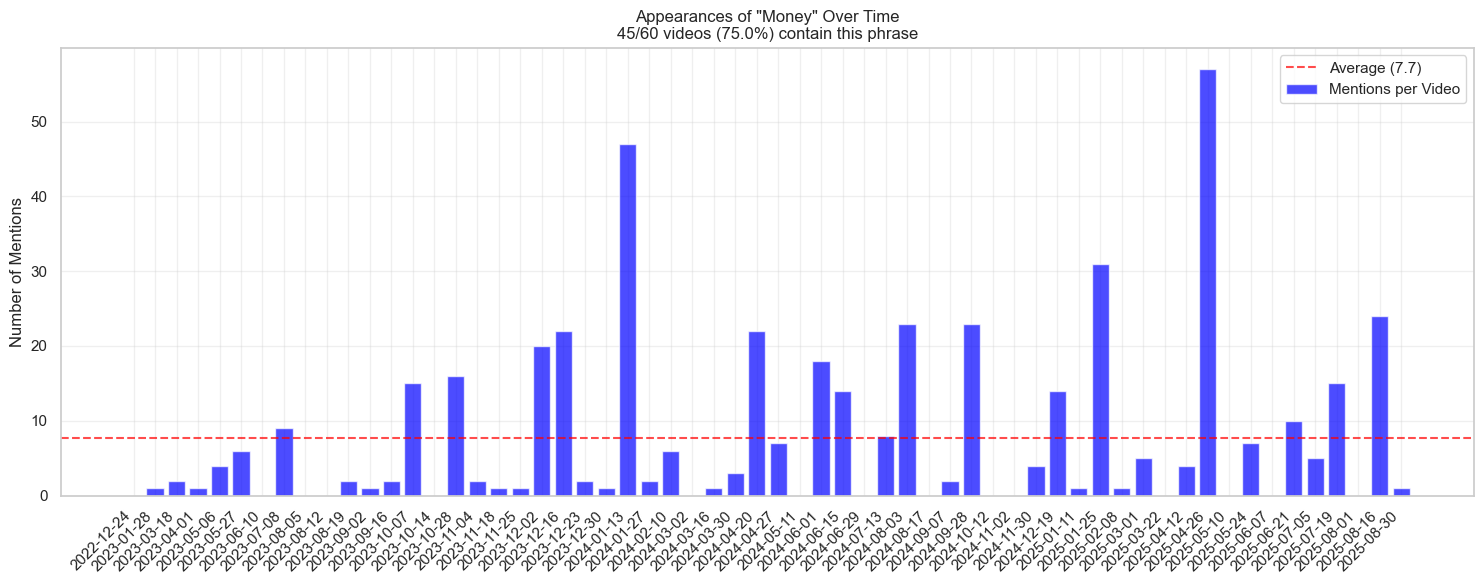

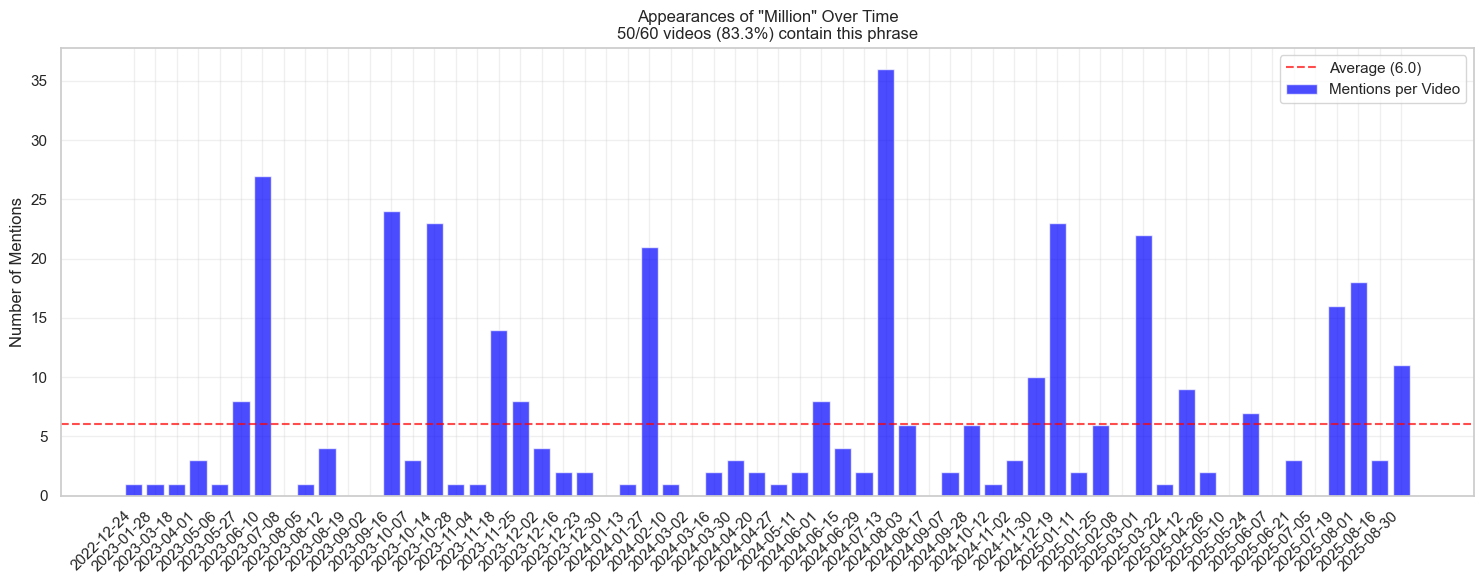

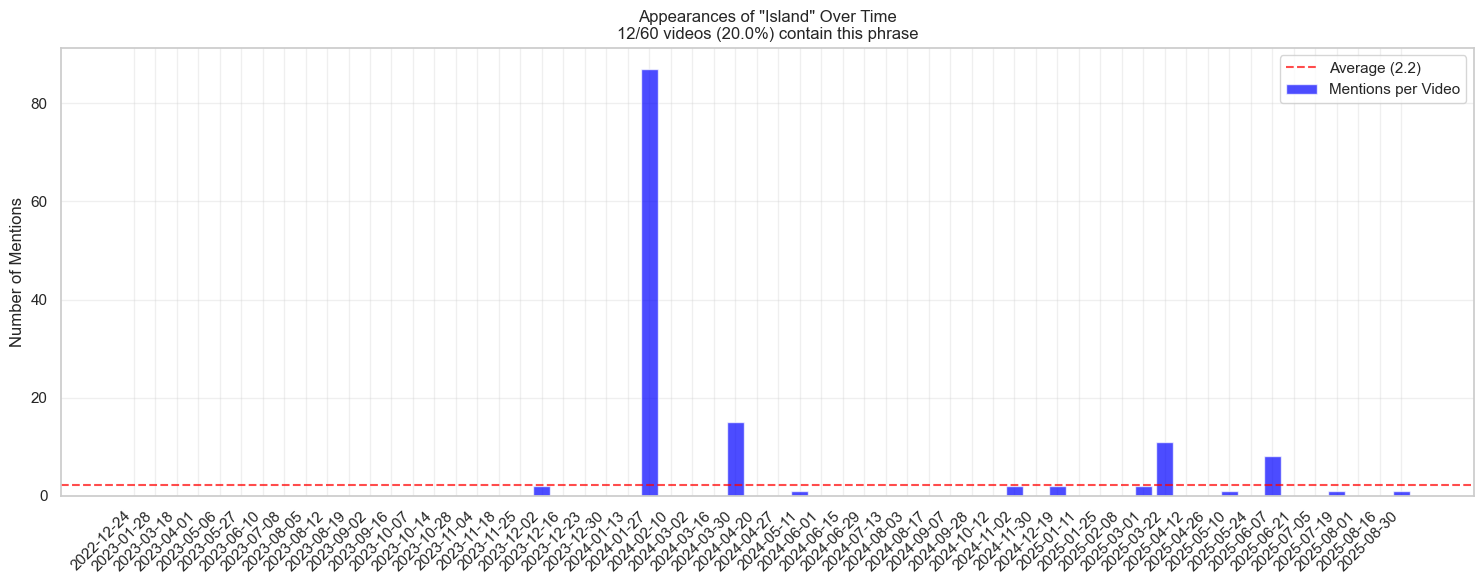

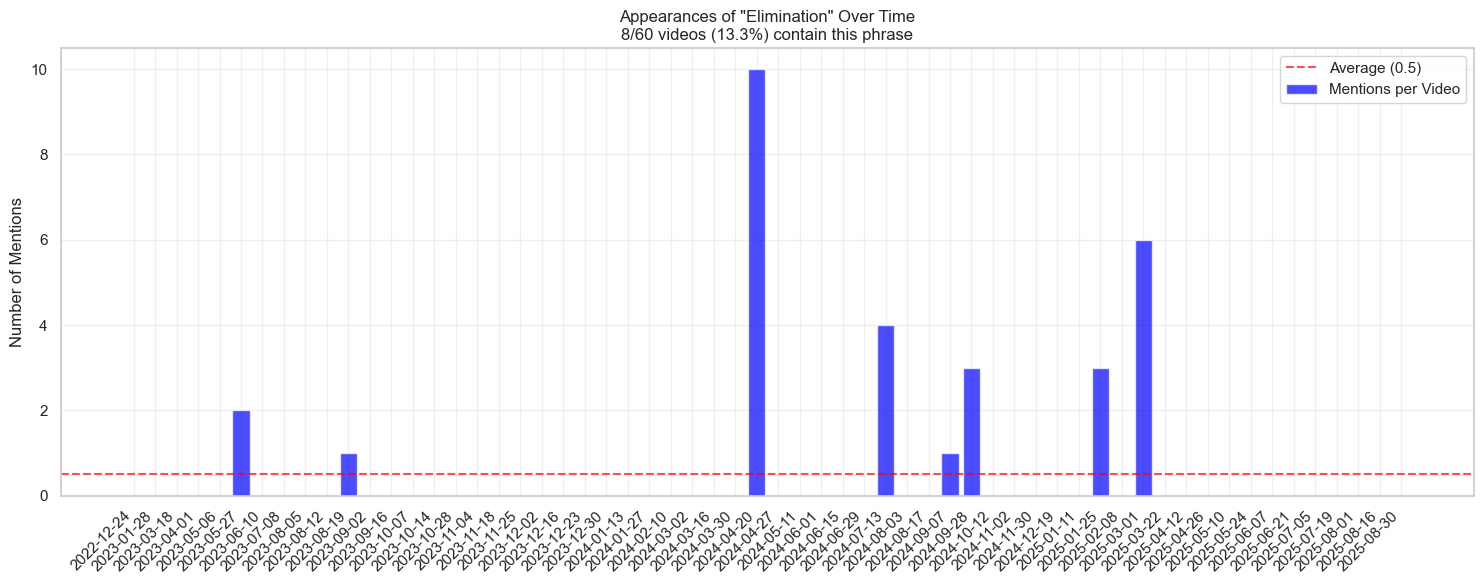

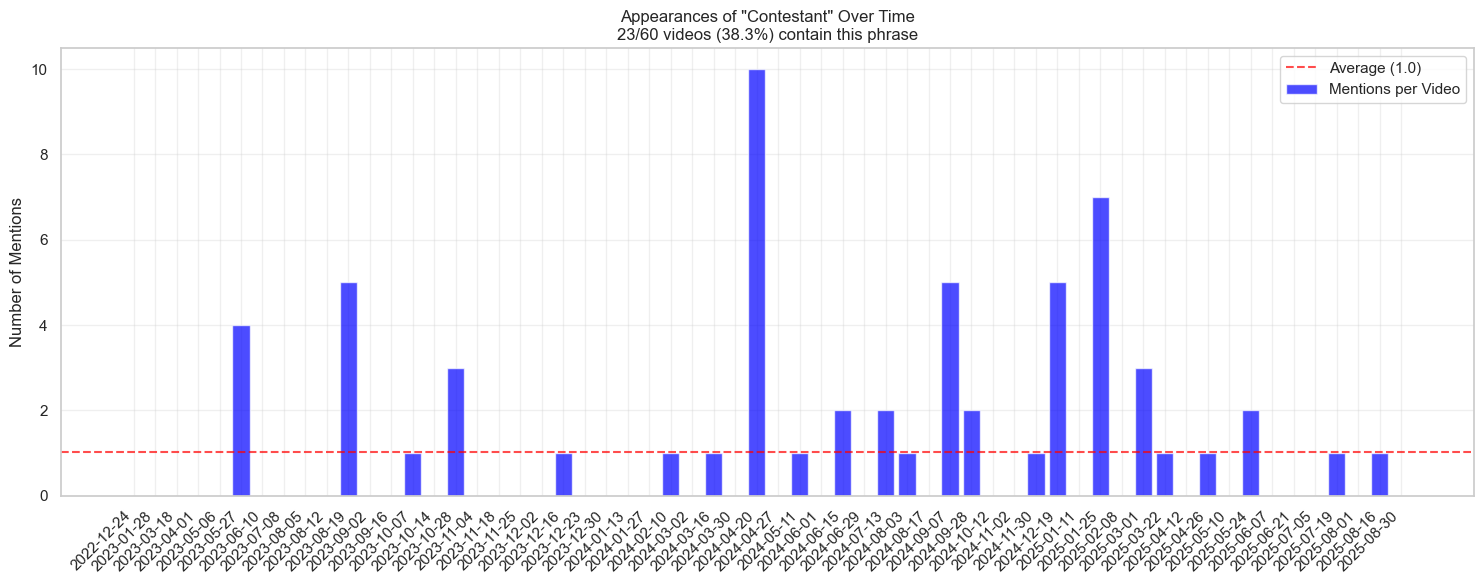

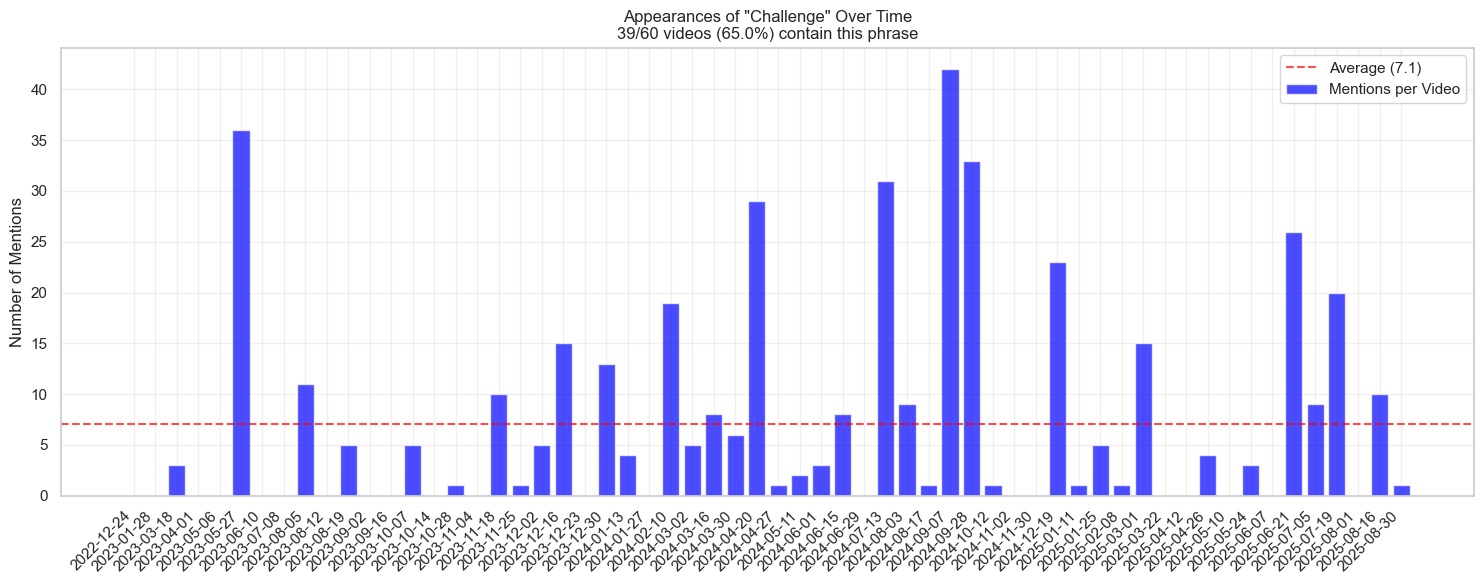

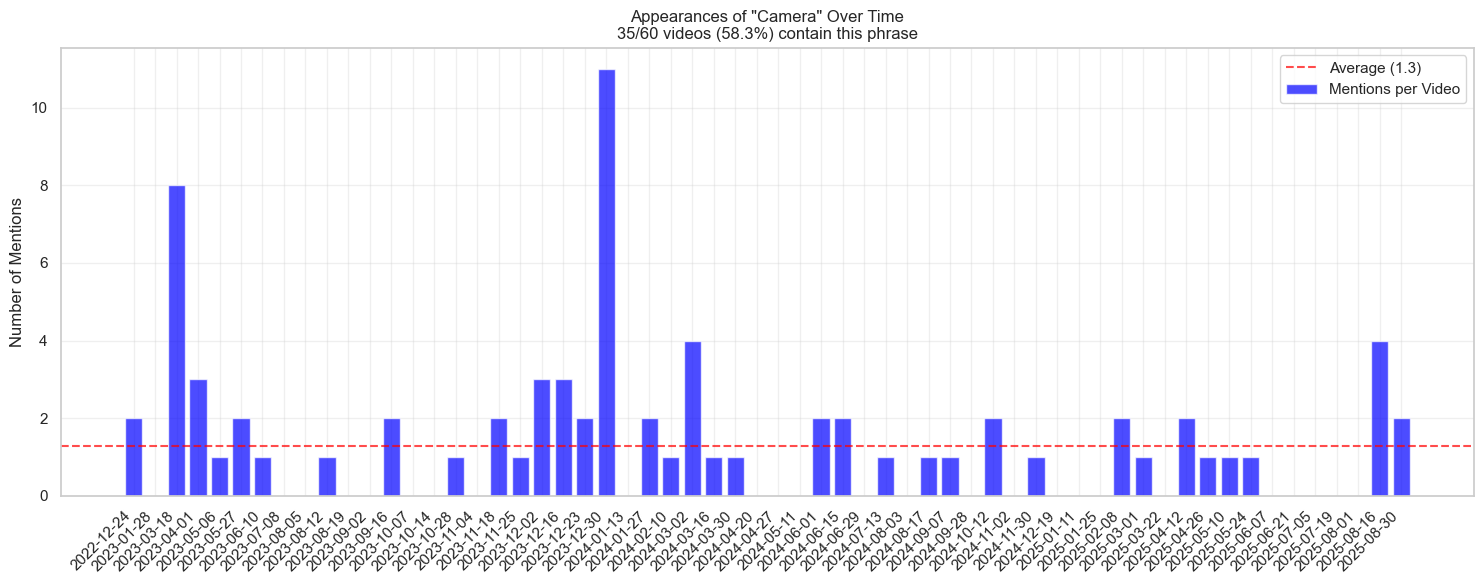

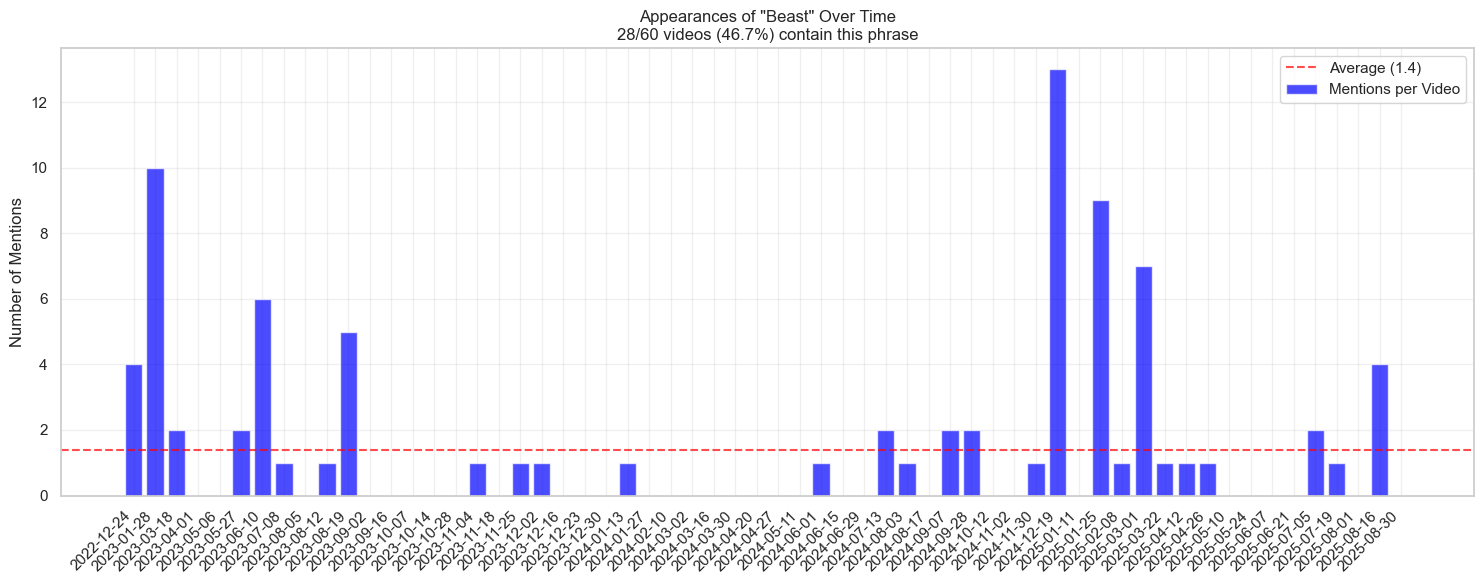

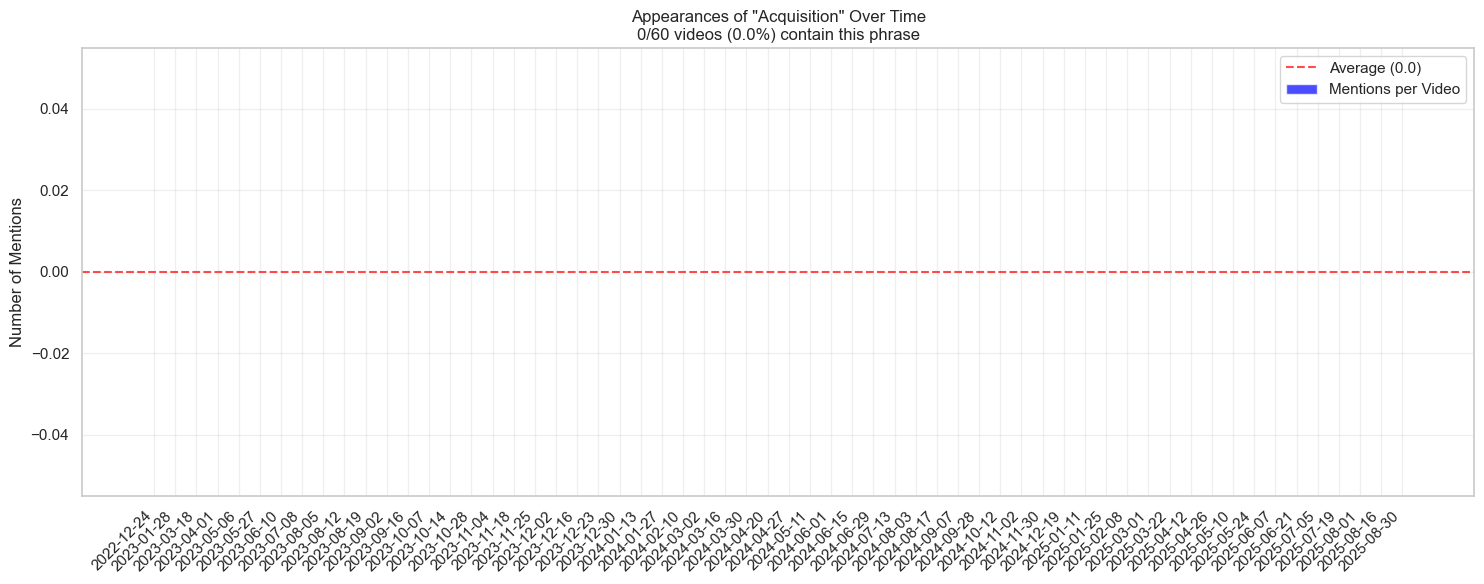

In [28]:
def plot_phrase_frequency_over_time(df, phrase):
    plt.figure(figsize=(15, 6))
    df_sorted = df.sort_values('date')
    counts = df_sorted[phrase]
    dates = df_sorted['date']
    avg = counts.mean()
    videos_with_mentions = (counts > 0).sum()
    total_videos = len(counts)
    percentage = (videos_with_mentions / total_videos) * 100
    x_positions = range(len(counts))
    plt.bar(x_positions, counts, alpha=0.7, color='blue', label='Mentions per Video')
    plt.axhline(y=avg, color='red', linestyle='--', alpha=0.7, label=f'Average ({avg:.1f})')
    plt.xticks(x_positions, [d.strftime('%Y-%m-%d') if pd.notna(d) else '' for d in dates], rotation=45, ha='right')
    plt.title(f'Appearances of "{phrase}" Over Time\n{videos_with_mentions}/{total_videos} videos ({percentage:.1f}%) contain this phrase')
    plt.xlabel('')
    plt.ylabel('Number of Mentions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

for phrase in SEARCH_PHRASES.keys():
    plot_phrase_frequency_over_time(df, phrase)


In [29]:
def get_recent_contexts(df, phrase, n=5):
    all_matches = []
    for _, row in df.sort_values('date', ascending=False).iterrows():
        matches = find_phrase_context(row['text'], SEARCH_PHRASES[phrase])
        for match in matches:
            all_matches.append({'date': row['date'], 'title': row.get('title',''), 'context': match})
        if len(all_matches) >= n:
            break
    return pd.DataFrame(all_matches[:n])

for phrase in SEARCH_PHRASES.keys():
    contexts = get_recent_contexts(df, phrase)
    if not contexts.empty:
        print(f"\n=== Recent usage of '{phrase}' ===\n")
        for _, row in contexts.iterrows():
            print(f"Date: {row['date'].strftime('%Y-%m-%d') if pd.notna(row['date']) else ''}")
            print(f"Title: {row['title']}")
            print(f"Context: {row['context']}\n")



=== Recent usage of 'Win' ===

Date: 2025-08-30
Title: World's Most Expensive Bunkers!
Context: ...h, it's 'cause we’re
3 stories underground.
- whoa!
- yeah.
where is this?
bro.
yeah, this is it.
this is the room.
wait, is this the video where we trapped
hugo and rayne in a bunker for 100 days
to win $500,000?
what do you guys think
of hugo and rayne?
- they always fight.
- i like ‘em.
what if i told you…
that was a signal for them
to come down the elevator,
and they're probably gonna be mad
this...

Date: 2025-08-16
Title: Survive 100 Days In Prison, Win $500,000
Context: ...this person to pay this person, lost everyone's money. but the problem became
i lied about the losses. so i ended up with
$500,000 of debt… which coincidentally is
the same amount of money they could win
in this video. meal time. guys, we got our first meal
in prison right here. this actually looks
better than prison. ian the criminal seems to be
right at home here. it's actually pretty cozy
down her...

Date: 2

In [30]:
## Video Titles in Chronological Order

def print_titles_chronologically(df):
    """Print all video titles in chronological order"""
    sorted_df = df.sort_values('date', ascending=True)
    print("Video Titles in Chronological Order:\n")
    for i, (_, row) in enumerate(sorted_df.iterrows(), 1):
        date_str = row['date'].strftime('%Y-%m-%d') if pd.notna(row['date']) else 'No date'
        title = row.get('title', 'No title')
        print(f"{i:2d}. {date_str} - {title}")

print_titles_chronologically(df)


Video Titles in Chronological Order:

 1. 2022-12-24 - I Survived 50 Hours In Antarctica
 2. 2023-01-28 - 1,000 Blind People See For The First Time
 3. 2023-03-18 - I Paid A Real Assassin To Try To Kill Me
 4. 2023-04-01 - World's Most Expensive Flights!
 5. 2023-05-06 - 1,000 Deaf People Hear For The First Time
 6. 2023-05-27 - Ages 1 - 100 Fight For $500,000
 7. 2023-06-10 - $1 vs $1,000,000,000 Yacht!
 8. 2023-07-08 - Train Vs Giant Pit
 9. 2023-08-05 - 7 Days Stranded At Sea
10. 2023-08-12 - $1 vs $250,000 Vacation!
11. 2023-08-19 - Every Country On Earth Fights For $250,000!
12. 2023-09-02 - Lamborghini Vs World's Largest Shredder
13. 2023-09-16 - $1 vs $100,000,000 Car!
14. 2023-10-07 - World's Most Dangerous Trap!
15. 2023-10-14 - $1 vs $100,000,000 House!
16. 2023-10-28 - 10 People Vs World's Deadliest Laser Maze for $250,000
17. 2023-11-04 - I Built 100 Wells In Africa
18. 2023-11-18 - I Spent 7 Days Buried Alive
19. 2023-11-25 - $1 vs $10,000,000 Job!
20. 2023-12-02 - $10,000